# Sensitivity analysis on WOFOST
*This Notebook is adopted from Steven Hoek and Allard de Wit, Wageningen Environmental Sciences* 

Sensitivity analysis is the study of how the uncertainty in the output of a mathematical model or system can be apportioned to different sources of uncertainty in its inputs. The sensitivity of each input is often represented by a numeric value, called the sensitivity index.

A limitation of this notebook is that is only applies for the scalar parameters in WOFOST. WOFOST also has a number of tabular parameters which are defined as a function of development stage or temperature. The sensitivity of these parameters cannot be properly analyzed with the approach used in this notebook.

Below the WOFOST model is run for a sugar beet crop in the Netherlands and then sensitivity analysis is applied. The target variable for sensitivity is the total weight of the storage organs (TWSO) which represents the crop yield. However, other variables can be chosen, such as total crop biomass or maximum leaf area index.

In [3]:
import sys, os.path

import yaml
import numpy as np
import pandas as pd
import seaborn as sns

from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", 250)

import pcse
from pcse.models import Wofost71_PP, Wofost71_WLP_FD
from pcse.base import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.fileinput import YAMLCropDataProvider
from pcse.util import WOFOST71SiteDataProvider, DummySoilDataProvider
from progressbar import printProgressBar
from pcse.fileinput import CABOFileReader
from pcse.engine import Engine

print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.9.1 (default, Jan  8 2021, 17:17:17) 
[Clang 12.0.0 (clang-1200.0.32.28)] 
PCSE version: 5.4.2


## WOFOST parameters
The table below gives an overview of all the important scalar WOFOST parameters.

In [4]:
df = pd.read_excel("docs/ScalarParametersOfWofost-All.xlsx")
display(df)

,Name,Typical Value,Category,Description,Unit
0,CFET,1.0000,Water use,correction factor for evapotranspiration,-
1,CVL,0.7200,Conversion of assimilates into biomass,efficiency conversion of assimilates into leaf dry matter,kg / kg
2,CVO,0.8200,Conversion of assimilates into biomass,efficiency conversion of assimilates into storage organ dry matter,kg / kg
3,CVR,0.7200,Conversion of assimilates into biomass,efficiency conversion of assimilates into root dry matter,kg / kg
4,CVS,0.6900,Conversion of assimilates into biomass,efficiency conversion of assimilates into stem dry matter,kg / kg
5,DEPNR,2.0000,Water use,crop group number,-
6,DLC,-99.0000,Phenology,critical day length for development (lower threshold),hours
7,DLO,-99.0000,Phenology,optimum day length for development,hours
8,DVS_NPK_STOP,1.5000,DVS related to N-P-K uptake and translocation,development stage after which no crop N-P-K uptake occurs,-
9,DVS_NPK_TRANSL,0.8000,DVS related to N-P-K uptake and translocation,development stage after which N-P-K translocation to storage organs occurs,-


## Settings for crop and location
We run the WOFOST simulation for maize in the United States in the "potential production" setting. Please rerun the sensitivity analysis for a different crop or a location and with different WOFOST model settings such as "water-limited production" and "nutrient-limited production".

In [5]:
## Define location, crop and season
latitude, longitude = 43.2, -94.2 # 52.2, 5.0
crop_name = 'maize'
variety_name = 'Grain_maize_201'
campaign_start_date = '2000-05-01'
plant_date = "2000-05-15"
harvest_date = "2000-11-15"
max_duration = 300

# Here we define the agromanagement for sugar beet, no irrigation or fertilization applied
agro_yaml = """
- {start}:
    CropCalendar:
        crop_name: {cname}
        variety_name: {vname}
        crop_start_date: {startdate}
        crop_start_type: sowing
        crop_end_date: {enddate}
        crop_end_type: maturity
        max_duration: {maxdur}
    TimedEvents: null
    StateEvents: null
""".format(cname=crop_name, vname=variety_name, 
           start=campaign_start_date, startdate=plant_date, 
           enddate=harvest_date, maxdur=max_duration)
agromanagement = yaml.safe_load(agro_yaml)
print(agro_yaml)

# Weather data 
wdp = NASAPowerWeatherDataProvider(latitude=latitude, longitude=longitude)
print(wdp)

# Parameter sets for crop, soil and site
# Standard crop parameter library
cropd = YAMLCropDataProvider()
# We don't need soil values for potential production, so we use dummy values
soild = DummySoilDataProvider()
# Some site parameters
sited = WOFOST71SiteDataProvider(WAV=50, CO2=360.)

# Retrieve all parameters in the form of a single object. 
# In order to see all parameters for the selected crop already, we
# synchronise data provider cropd with the crop/variety: 
firstkey = list(agromanagement[0])[0]
cropcalendar = agromanagement[0][firstkey]['CropCalendar'] 
cropd.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)
print(params)


- 2000-05-01:
    CropCalendar:
        crop_name: maize
        variety_name: Grain_maize_201
        crop_start_date: 2000-05-15
        crop_start_type: sowing
        crop_end_date: 2000-11-15
        crop_end_type: maturity
        max_duration: 300
    TimedEvents: null
    StateEvents: null

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER SRB/FLASHFlux/MERRA2/GEOS 5.12.4 (FP-IT) 0.5 x 0.5 Degree Daily Averaged Data
----Site characteristics----
Elevation:  362.6
Latitude:  43.200
Longitude: -94.200
Data available for 1983-07-01 - 2021-07-13
Number of missing days: 31

ParameterProvider providing 105 parameters, 0 parameters overridden: dict_keys([]).


In [6]:
soild

{'SMFCF': 0.3,
 'SM0': 0.4,
 'SMW': 0.1,
 'RDMSOL': 120,
 'CRAIRC': 0.06,
 'K0': 10.0,
 'SOPE': 10.0,
 'KSUB': 10.0}

In [7]:
cropd

{'CO2EFFTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.0, 1000.0, 1.0, 2000.0, 1.0],
 'CO2TRATB': [40.0, 0.0, 360.0, 1.0, 720.0, 0.74, 1000.0, 0.74, 2000.0, 0.74],
 'CO2AMAXTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.0, 1000.0, 1.0, 2000.0, 1.0],
 'TBASEM': 4.0,
 'TEFFMX': 30.0,
 'TSUMEM': 110,
 'IDSL': 0,
 'DLO': -99.0,
 'DLC': -99.0,
 'TSUM1': 695,
 'TSUM2': 800,
 'DTSMTB': [0.0, 0.0, 6.0, 0.0, 30.0, 24.0, 35.0, 24.0],
 'DVSI': 0.0,
 'DVSEND': 2.0,
 'VERNBASE': 14.0,
 'VERNSAT': 70.0,
 'VERNDVS': 0.3,
 'VERNRTB': [-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17.0, 0.0, 20.0, 0.0],
 'TDWI': 50.0,
 'RGRLAI': 0.0294,
 'SLATB': [0.0, 0.0026, 0.78, 0.0012, 2.0, 0.0012],
 'SPA': 0.0,
 'SSATB': [0.0, 0.0, 2.0, 0.0],
 'SPAN': 33.0,
 'TBASE': 10.0,
 'KDIFTB': [0.0, 0.6, 2.0, 0.6],
 'EFFTB': [0.0, 0.45, 40.0, 0.45],
 'AMAXTB': [0.0, 70.0, 1.25, 70.0, 1.5, 63.0, 1.75, 49.0, 2.0, 21.0],
 'TMPFTB': [0.0,
  0.01,
  9.0,
  0.05,
  16.0,
  0.8,
  18.0,
  0.94,
  20.0,
  1.0,
  30.0,
  1.0,
  36.0,
  0.95,
  42.0,
  

In [8]:
sited

{'IFUNRN': 0,
 'NOTINF': 0,
 'SSI': 0.0,
 'SSMAX': 0.0,
 'WAV': 50.0,
 'SMLIM': 0.4,
 'CO2': 360.0}

## Defining the analysis
Sensitivity analysis involves that we vary the model parameters a bit, to see how sensitive the model is to inaccuracies / variations in those values. We focus on variations in the model parameters and not on inaccuracies in e.g. rainfall figures. 

In the following, intervals are defined for parameters. It is necessary to acquire knowledge of what are realistic values for the parameters which are often crop specific.

In [9]:
# Define the target variable
target_variable = "TWSO" # total dry weight of storage organs (dead and living) (kg ha-1)
# target_variable = "LAIMAX" # maximum leaf area index

# For each scalar parameter, determine a sensible interval 
# Sensitivity Analysis for Crop Variables
problem_yaml = """
    num_vars: 22
    names: 
    - TSUM1
    - TSUM2
    - SPAN
    - Q10
    - TDWI
    - CVL
    - CVO
    - CVR
    - CVS
    - CFET
    - TBASEM
    - TEFFMX
    - TSUMEM
    - DLO
    - DLC
    - TBASE
    - RGRLAI
    - RML
    - RMO
    - RMR
    - RMS
    - PERDL


    bounds:
    - [150, 1050]
    - [600, 1550]
    - [17, 50]
    - [1.5, 2.0]
    - [0.5, 300]
    - [0.6, 0.76]
    - [0.45, 0.85]
    - [0.65, 0.76]
    - [0.63, 0.76]
    - [0.8, 1.2]
    - [-10, 8]
    - [18, 32]
    - [0, 170]
    - [6, 18]
    - [6, 18]
    - [-10, 10]
    - [0.007, 0.5]
    - [0.02700, 0.03000]
    - [0.00300, 0.01700]
    - [0.01000, 0.01500]
    - [0.01500, 0.02000]
    - [0, 0.1]
"""

problem = yaml.safe_load(problem_yaml)

In [10]:
# Sensitivity Analysis for Soil Variables
# problem_yaml = """
#     num_vars: 5
#     names: 
#     - SMW
#     - SMFCF
#     - K0
#     - SOPE
#     - KSUB
#     bounds:
#     - [0.01, 0.35]
#     - [0.05, 0.74]
#     - [0.1, 100]
#     - [0.1, 100]
#     - [0.1, 100]
# """


# Sensitivity Analysis for Soil Variables
# problem_yaml = """
#     num_vars: 8
#     names: 
#     - SMW
#     - SMFCF
#     - SM0
#     - CRAIRC
#     - RDMSOL
#     - K0
#     - SOPE
#     - KSUB

    
#     bounds:
#     - [0.1, 0.35000]
#     - [0.1, 0.74000]
#     - [0.30000, 0.90000]
#     - [0.04, 0.1]
#     - [100, 140]
#     - [0.1, 1]
#     - [0.1, 1]
#     - [0.1, 1]
# """

# problem = yaml.safe_load(problem_yaml)

## First and second order sensitivities
When running a sensitivity analysis, we may compute first and second order sensitivities. Calculating second order sensitivities may require a large number of models runs if the number of parameters is large.

In this examples we use the Saltelli sampler to sample a number of combinations of parameter values and we will derive first and second order sensitivity. The variable `nsamples` indicates the number of samples to generate, higher values will provide better estimates of sensitivity but increase computation time.

In [12]:
calc_second_order = True
nsamples = 64 # Play with this number -> 2^n 
paramsets = saltelli.sample(problem, nsamples, calc_second_order=calc_second_order)
print(problem)
print(paramsets)
print("We are going to do %s simulations" % len(paramsets))

{'num_vars': 22, 'names': ['TSUM1', 'TSUM2', 'SPAN', 'Q10', 'TDWI', 'CVL', 'CVO', 'CVR', 'CVS', 'CFET', 'TBASEM', 'TEFFMX', 'TSUMEM', 'DLO', 'DLC', 'TBASE', 'RGRLAI', 'RML', 'RMO', 'RMR', 'RMS', 'PERDL'], 'bounds': [[150, 1050], [600, 1550], [17, 50], [1.5, 2.0], [0.5, 300], [0.6, 0.76], [0.45, 0.85], [0.65, 0.76], [0.63, 0.76], [0.8, 1.2], [-10, 8], [18, 32], [0, 170], [6, 18], [6, 18], [-10, 10], [0.007, 0.5], [0.027, 0.03], [0.003, 0.017], [0.01, 0.015], [0.015, 0.02], [0, 0.1]], 'sample_scaled': True}
[[1.50000000e+02 6.00000000e+02 1.70000000e+01 ... 1.00000000e-02
  1.50000000e-02 0.00000000e+00]
 [1.50000000e+02 6.00000000e+02 1.70000000e+01 ... 1.00000000e-02
  1.50000000e-02 0.00000000e+00]
 [1.50000000e+02 6.00000000e+02 1.70000000e+01 ... 1.00000000e-02
  1.50000000e-02 0.00000000e+00]
 ...
 [5.01562500e+02 1.11953125e+03 4.84531250e+01 ... 1.08593750e-02
  1.61718750e-02 1.71875000e-02]
 [5.01562500e+02 1.11953125e+03 4.84531250e+01 ... 1.08593750e-02
  1.74218750e-02 5.468

## Running the model
Below we are going to loop over the parameter sets sampled by the Saltelli sampler.

In [13]:
nsets = len(paramsets)
printProgressBar(0, nsets, prefix='Progress:', suffix='Complete', length=nsamples)

# Loop over the samples of the parameter values and run WOFOST for each of the samples
target_results = []
for i, paramset in enumerate(paramsets):
    params.clear_override()
    for name, value in zip(problem["names"], paramset):
        params.set_override(name, value)
    #wofost = Engine(params, wdp, agromanagement, config) #WLP_NPK
#     wofost = Wofost71_PP(params, wdp, agromanagement) # potential
    try:
        wofost = Wofost71_WLP_FD(params, wdp, agromanagement) # potential
        wofost.run_till_terminate()
        r = wofost.get_summary_output()
        target_result = r[0][target_variable]
        if target_result is None:
            print("Target variable is not available in summary output!")
            break
        target_results.append(target_result)
    except:
        continue
    printProgressBar(i+1, nsets, prefix='Progress:', suffix='Complete', length=nsamples)

target_results = np.array(target_results)

Progress: |████████████████████████████████████████████████████████████████| 100.0% Complete


In [14]:
# print(target_results)

# Computing sensitivity indices
We will use the [Sobol](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis) method to assess the response of the model to the variations in the parameters. Besides Sobol, other known methods are Morris and FAST. See also: https://salib.readthedocs.io/en/latest/.

For example, given a model with two inputs and one output, one might find that 70% of the output variance is caused by the variance in the first input, 20% by the variance in the second, and 10% due to interactions between the two. These percentages are directly interpreted as measures of sensitivity. Variance-based measures of sensitivity are attractive because they measure sensitivity across the whole input space (i.e. it is a global method), they can deal with nonlinear responses, and they can measure the effect of interactions.



In [15]:
# Use the Sobol method to analyse the results of the simulations
Si = sobol.analyze(problem, target_results, calc_second_order=calc_second_order)

In [16]:
# Si

## Plotting results
After running the cell below, a chart with first order and total order sensitivity is drawn. The first order  sensitivity index for a parameter represents the fraction of the variance in the target variable caused by the variation in the input parameter. Total order indices represent the total variance in the target variable for a given parameter, including all variance caused by its interactions, of any order, with any other input variable. 

In many models there are statistical dependencies between parameters or physical constraints on the model. In such cases part of the variance in the output is also caused by interactions between variables which is not represented by the first order indices. In such cases, second order indices need to be calculated. If the total-order indices are substantially larger than the first-order indices, then it is likely that there are higher-order interactions occurring. It means that if both parameters are changed at the same time, it will have a large effect on the target variable.

Note that indices do not necessarily add up to unity and often indices can become slightly negative due to sampling error. Such negative index values would disappear if the number of samples would be increased.

<AxesSubplot:title={'center':'Sensitivity Index of Crop Parameters on TWSO'}, xlabel='Crop Parameters', ylabel='Sensitivity Index (%)'>

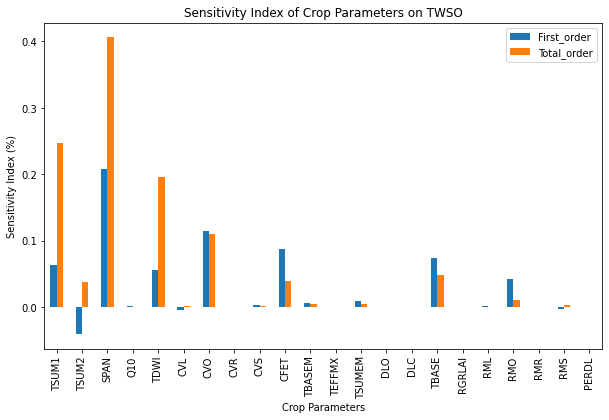

In [17]:
df_sensitivity = pd.DataFrame({
    "Parameter": problem["names"],
    "First_order": Si["S1"],
    "Total_order": Si["ST"]}).set_index("Parameter")
fig, axes = plt.subplots(figsize=(10,6))
df_sensitivity.plot(kind="bar", ax=axes,
                    title=f'Sensitivity Index of Crop Parameters on {target_variable}',
                    ylabel='Sensitivity Index (%)',
                    xlabel='Crop Parameters')

## Second order sensitivities
Second order sensitivities deal with the combined sensitivity of two parameters. The results can therefore most easily be visualized through a matrix 

In [18]:
# Show second-order sensitivities
second_order = np.array(Si['S2'])
pd.DataFrame(second_order, index=problem["names"], columns=problem["names"])

,TSUM1,TSUM2,SPAN,Q10,TDWI,CVL,CVO,CVR,CVS,CFET,...,TSUMEM,DLO,DLC,TBASE,RGRLAI,RML,RMO,RMR,RMS,PERDL
TSUM1,NaN,0.169624,0.160329,0.126931,0.308684,0.128636,0.114455,0.129603,0.135694,0.139674,...,0.144158,0.130477,0.130477,1.148381e-01,1.303037e-01,1.303306e-01,1.100403e-01,1.319785e-01,1.334276e-01,1.309216e-01
TSUM2,NaN,NaN,0.014126,0.012433,-0.002021,0.012008,0.019948,0.012483,0.011420,0.001277,...,0.009773,0.012710,0.012710,4.234019e-03,1.271413e-02,1.256417e-02,5.863624e-03,1.255811e-02,1.136347e-02,1.306668e-02
SPAN,NaN,NaN,NaN,-0.116174,0.042811,-0.122013,-0.124692,-0.120936,-0.116301,-0.133244,...,-0.109989,-0.120843,-0.120843,-4.636306e-02,-1.208923e-01,-1.215654e-01,-1.317165e-01,-1.205180e-01,-1.242525e-01,-1.215002e-01
Q10,NaN,NaN,NaN,NaN,0.000356,0.000540,0.001221,0.000520,0.000543,-0.001983,...,0.000789,0.000473,0.000473,-1.798032e-03,4.722904e-04,5.047918e-04,-1.257088e-04,4.961167e-04,7.948837e-04,5.044184e-04
TDWI,NaN,NaN,NaN,NaN,NaN,0.083392,0.050487,0.084694,0.083108,0.088573,...,0.081598,0.083491,0.083491,8.053260e-02,8.343029e-02,8.314651e-02,7.354077e-02,8.419067e-02,8.174496e-02,8.176815e-02
CVL,NaN,NaN,NaN,NaN,NaN,NaN,-0.000311,-0.001930,-0.001444,-0.001246,...,-0.001496,-0.001839,-0.001839,-2.584467e-03,-1.842962e-03,-1.815155e-03,-1.511404e-03,-1.836871e-03,-1.333285e-03,-1.820777e-03
CVO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.044795,-0.048030,-0.032842,...,-0.057911,-0.046421,-0.046421,-3.763957e-02,-4.640663e-02,-4.622641e-02,-4.273222e-02,-4.589701e-02,-4.364146e-02,-4.674536e-02
CVR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000754,0.000047,...,0.000677,0.000758,0.000758,1.734574e-03,7.584306e-04,7.588806e-04,5.138863e-04,7.818142e-04,6.330256e-04,7.681115e-04
CVS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008250,...,-0.008239,-0.008059,-0.008059,-7.805590e-03,-8.054802e-03,-8.025674e-03,-6.299562e-03,-8.257084e-03,-8.210246e-03,-7.978075e-03
CFET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.099360,-0.100833,-0.100833,-1.181272e-01,-1.008328e-01,-1.009635e-01,-1.155523e-01,-1.018138e-01,-1.018484e-01,-1.001266e-01


or through an image showing the values in the matrix values graphically. From the results, it is clear that the second order interactions are small as all indices have a value < 0.1.

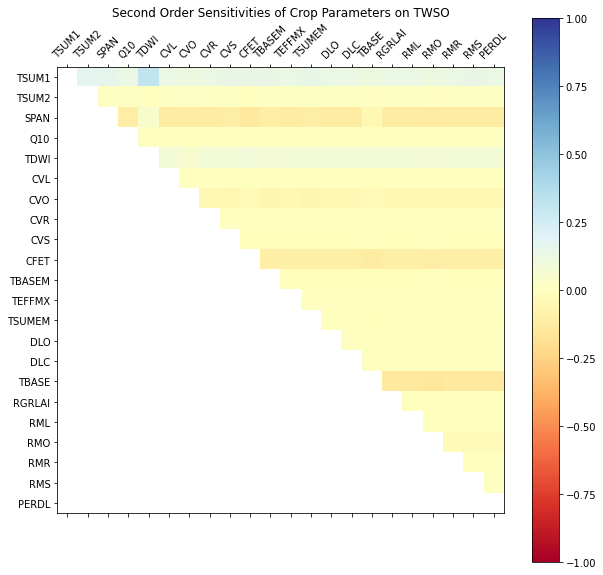

In [19]:
# Visualise second-order sensitivities
fig, axes = plt.subplots(figsize=(10,10))
aximage = axes.matshow(second_order, vmin=-1.0, vmax=1.0, cmap="RdYlBu")
cbar = fig.colorbar(aximage)
aximage.axes.set_xticks(range(len(problem["names"])))
aximage.axes.set_xticklabels(problem["names"], rotation=45)
aximage.axes.set_yticks(range(len(problem["names"])))
aximage.axes.set_yticklabels(problem["names"])
r = aximage.axes.set_title(f"Second Order Sensitivities of Crop Parameters on {target_variable}")


In [20]:
df_sensitivity.head(10)

,First_order,Total_order
Parameter,,
TSUM1,0.063479,0.247471
TSUM2,-0.040489,0.037103
SPAN,0.207478,0.406179
Q10,0.002071,0.000418
TDWI,0.056066,0.195756
CVL,-0.005226,0.000903
CVO,0.114469,0.109200
CVR,-0.000788,0.000197
CVS,0.003549,0.001212


# Generate distributions of input parameters to plot output distributions

In [22]:
def generate_dist(param_name, mu, std, n_samples, target_variable):
    param_values = np.linspace(start=mu-std, stop=mu+std, num=n_samples)  #650 - temp. sum from emergence to anthesis [cel d]
    results = []
    
    for param in param_values:
        params.clear_override()
        params.set_override(param_name, param)
        # wofost = Engine(params, wdp, agromanagement, config) # WLP_NPK
        wofost = Wofost71_PP(params, wdp, agromanagement) # potential production
        wofost.run_till_terminate()
        r = wofost.get_summary_output()
        results.append(r[0][target_variable])

    df = pd.DataFrame({param_name: param_values,
                       target_variable: results}
                     ).set_index(param_name)
    
    return df


def generate_dist2(param_name, lower_bound, upper_bound, n_samples, target_variable):
    param_values = np.linspace(start=lower_bound, stop=upper_bound, num=n_samples)  #650 - temp. sum from emergence to init. beet growth [cel d]
    results = []
    for param in param_values:
        params.clear_override()
        params.set_override(param_name, param)
        # wofost = Engine(params, wdp, agromanagement, config) # WLP_NPK
        wofost = Wofost71_PP(params, wdp, agromanagement) # potential production
        wofost.run_till_terminate()
        r = wofost.get_summary_output()
        results.append(r[0][target_variable])

    df = pd.DataFrame({param_name: param_values,
                       target_variable: results}
                     ).set_index(param_name)
    
    return df

In [23]:
from scipy.stats import norm

def generate_noisy_dist(mu, sigma, n_samples, param_name,):
    s = np.random.normal(mu, sigma, n_samples)    
    sns.distplot(s, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},)
    plt.title(f'{param_name} distribution')
    plt.xlabel(param_name)
    plt.show()
    return s
    
def generate_wofost_dist(param_name, input_dist, target_variable):
    results = []
    for param in input_dist:
        params.clear_override()
        params.set_override(param_name, param)
        wofost = Wofost71_PP(params, wdp, agromanagement) #potential production
        wofost.run_till_terminate()
        r = wofost.get_summary_output()
        results.append(r[0][target_variable])
    df = pd.DataFrame({param_name: input_dist,
                       target_variable: results}
                     ).set_index(param_name)
    
    sns.distplot(results, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},)
    plt.title(f'{target_variable} distribution')
    plt.xlabel(param_name)
    plt.show()
    return df, results

/Users/sulekahraman/Desktop/wofost-study/venv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


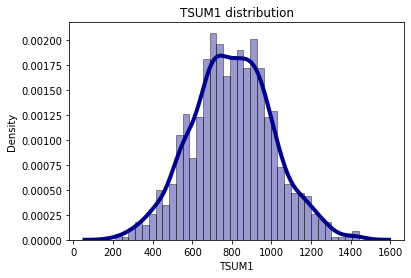

In [24]:
mu = 800
sigma = 200
param_name = "TSUM1"
n_samples = 1000
target_variable = "TWSO"
input_dist = generate_noisy_dist(mu, sigma, n_samples, param_name)

/Users/sulekahraman/Desktop/wofost-study/venv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


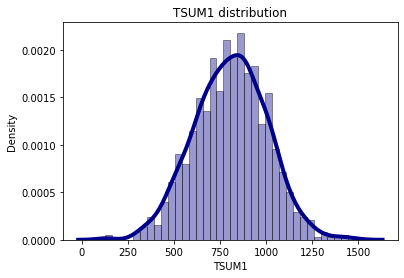

/Users/sulekahraman/Desktop/wofost-study/venv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


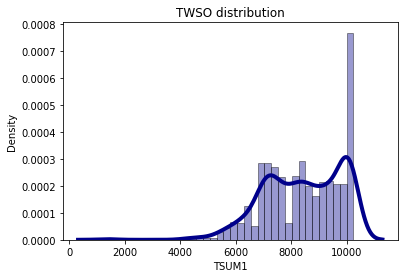

,TWSO
TSUM1,
1085.446680,6497.314766
999.784202,7102.416574
673.398517,10108.632449
916.922816,7658.950784
675.903548,10122.361369


In [25]:
mu = 800
sigma = 200
param_name = "TSUM1"
n_samples = 1000
target_variable = "TWSO"

input_dist = generate_noisy_dist(mu, sigma, n_samples, param_name)
df, results = generate_wofost_dist(param_name, input_dist, target_variable)
df.head()

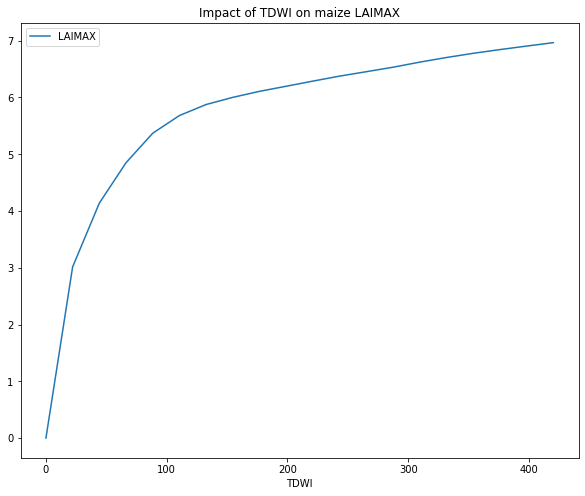

In [28]:
%matplotlib inline
mu = 210
std = mu*1
param_name = "TDWI"
n_samples = 20
target_variable = "LAIMAX"
df = generate_dist(param_name, mu, std, n_samples, target_variable)
r = df.plot(title=f"Impact of {param_name} on maize {target_variable}", figsize=(10,8))

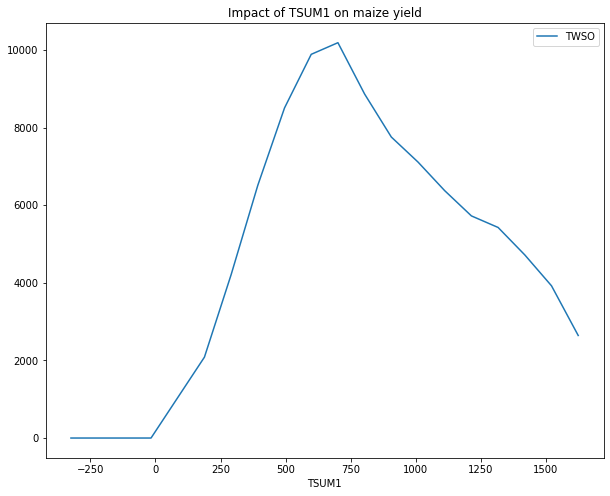

In [29]:
%matplotlib inline
mu = 650
std = mu*1.5
param_name = "TSUM1"
n_samples = 20
target_variable = "TWSO"
df = generate_dist(param_name, mu, std, n_samples, target_variable)
r = df.plot(title="Impact of {} on maize yield".format(param_name), figsize=(10,8))

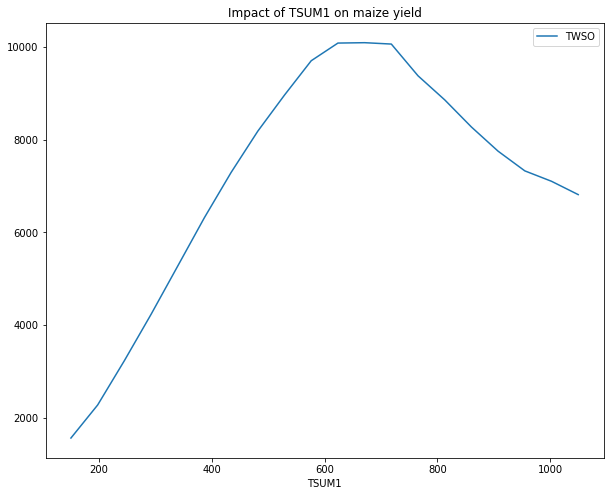

In [30]:
lower_bound = 150
upper_bound = 1050
param_name = "TSUM1"
n_samples = 20
target_variable = "TWSO"
df = generate_dist2(param_name, lower_bound, upper_bound, n_samples, target_variable)
r = df.plot(title="Impact of {} on maize yield".format(param_name), figsize=(10,8))

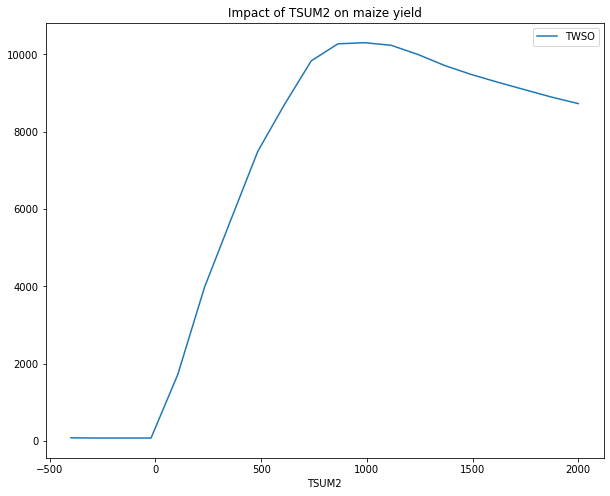

In [31]:
mu = 800
std = mu*1.5
param_name = "TSUM2"
n_samples = 20
target_variable = "TWSO"
df = generate_dist(param_name, mu, std, n_samples, target_variable)
r = df.plot(title="Impact of {} on maize yield".format(param_name), figsize=(10,8))

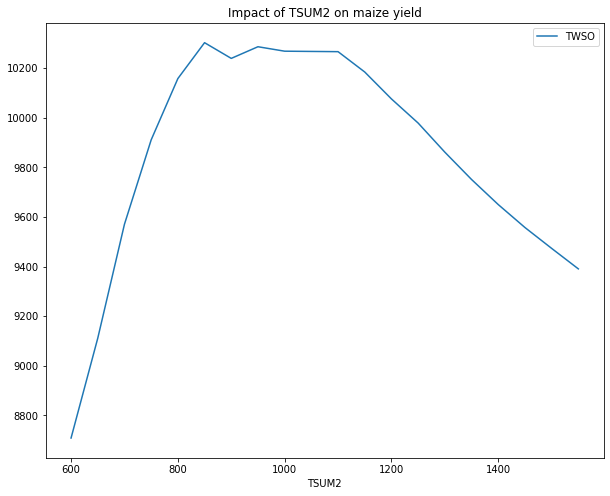

In [32]:
lower_bound = 600
upper_bound = 1550
param_name = "TSUM2"
n_samples = 20
target_variable = "TWSO"
df = generate_dist2(param_name, lower_bound, upper_bound, n_samples, target_variable)
r = df.plot(title="Impact of {} on maize yield".format(param_name), figsize=(10,8))

In [25]:
def generate_multi_dist(param_names, lower_bounds, upper_bounds, n_samples, target_variable):
    param_values = dict()
    for i in range(len(param_names)):
        param_name = param_names[i]
        param_values[param_name] = np.linspace(start=lower_bounds[i], stop=upper_bounds[i], num=n_samples)
    
    df = pd.DataFrame(columns=['TSUM1', 'TSUM2', target_variable])
    for tsum1 in param_values['TSUM1']:
        for tsum2 in param_values['TSUM2']:
            row = dict()
            params.clear_override()
            params.set_override('TSUM1', tsum1)
            params.set_override('TSUM2', tsum2)
            row['TSUM1'] = tsum1
            row['TSUM2'] = tsum2
            wofost = Wofost71_PP(params, wdp, agromanagement) # Potential production
            wofost.run_till_terminate()
            r = wofost.get_summary_output()
            res = r[0][target_variable]
            row[target_variable] = res
            df = df.append(row, ignore_index=True)
    return df

In [26]:
lower_bounds = np.array([150, 600])
upper_bounds = np.array([1050, 1550])
param_names = ["TSUM1", "TSUM2"]
n_samples = 20
target_variable = "TWSO"
df = generate_multi_dist(param_names, lower_bounds, upper_bounds, n_samples, target_variable)
df.head()

,TSUM1,TSUM2,TWSO
0,150.0,600.0,1310.189241
1,150.0,650.0,1350.183903
2,150.0,700.0,1393.439120
3,150.0,750.0,1435.639071
4,150.0,800.0,1472.911342


<IPython.core.display.Javascript object>


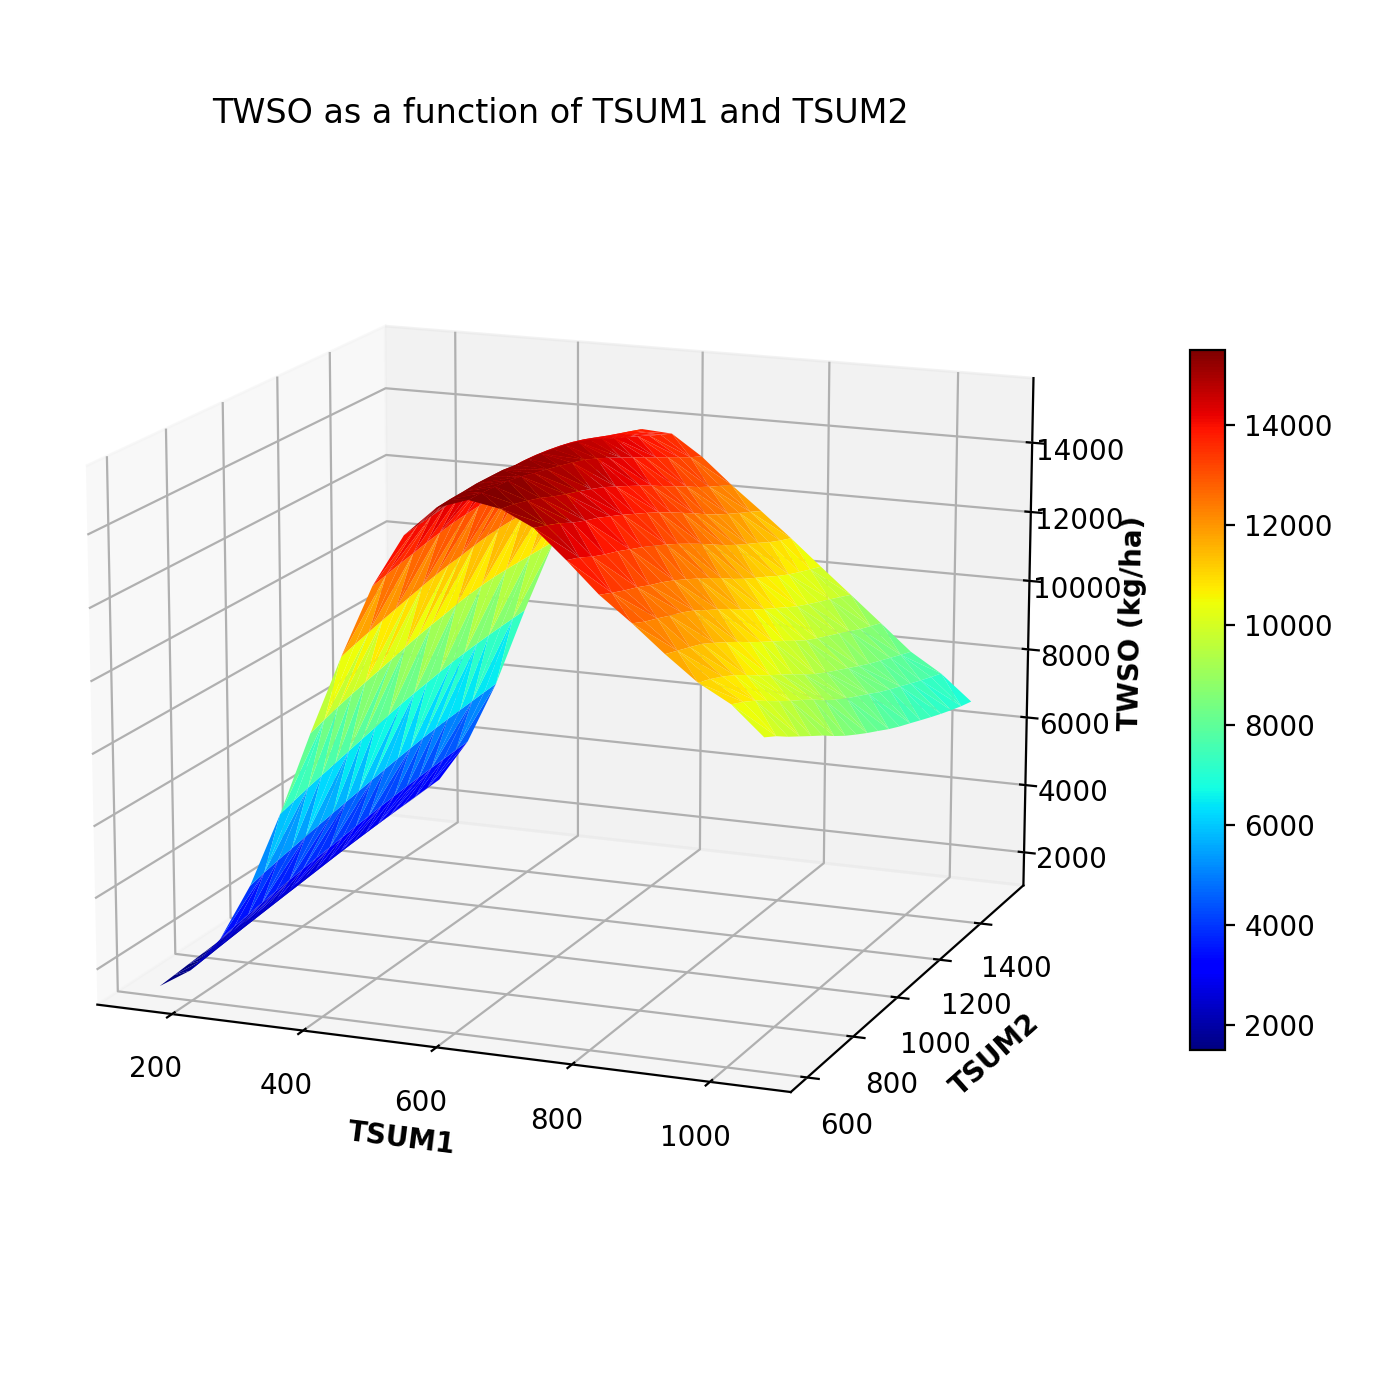

In [27]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig)
trisurf = ax.plot_trisurf(df.TSUM1, df.TSUM2, df.TWSO, cmap=cm.jet, linewidth=0.2)
fig.colorbar(trisurf, ax = ax, shrink = 0.5) 
ax.set_title('TWSO as a function of TSUM1 and TSUM2') 

# Adding labels 
ax.set_xlabel('TSUM1', fontweight ='bold')  
ax.set_ylabel('TSUM2', fontweight ='bold')  
ax.set_zlabel('TWSO (kg/ha)', fontweight ='bold') 

# show plot 
plt.show() 

In [29]:
# How does crop calendar depend on TSUM1 and TSUM2?
lower_bounds = np.array([150, 600])
upper_bounds = np.array([1050, 1550])
param_names = ["TSUM1", "TSUM2"]
n_samples = 10
target_variable = "DOA" # Date of anthesis
df = generate_multi_dist(param_names, lower_bounds, upper_bounds, n_samples, target_variable)
df.head()

,TSUM1,TSUM2,DOA
0,150.0,600.000000,2006-05-10
1,150.0,705.555556,2006-05-10
2,150.0,811.111111,2006-05-10
3,150.0,916.666667,2006-05-10
4,150.0,1022.222222,2006-05-10


In [37]:
df['Days to Anthesis'] = pd.to_datetime(df['DOA']).apply(lambda x: (x-pd.to_datetime(emergence_date)).days)

<IPython.core.display.Javascript object>


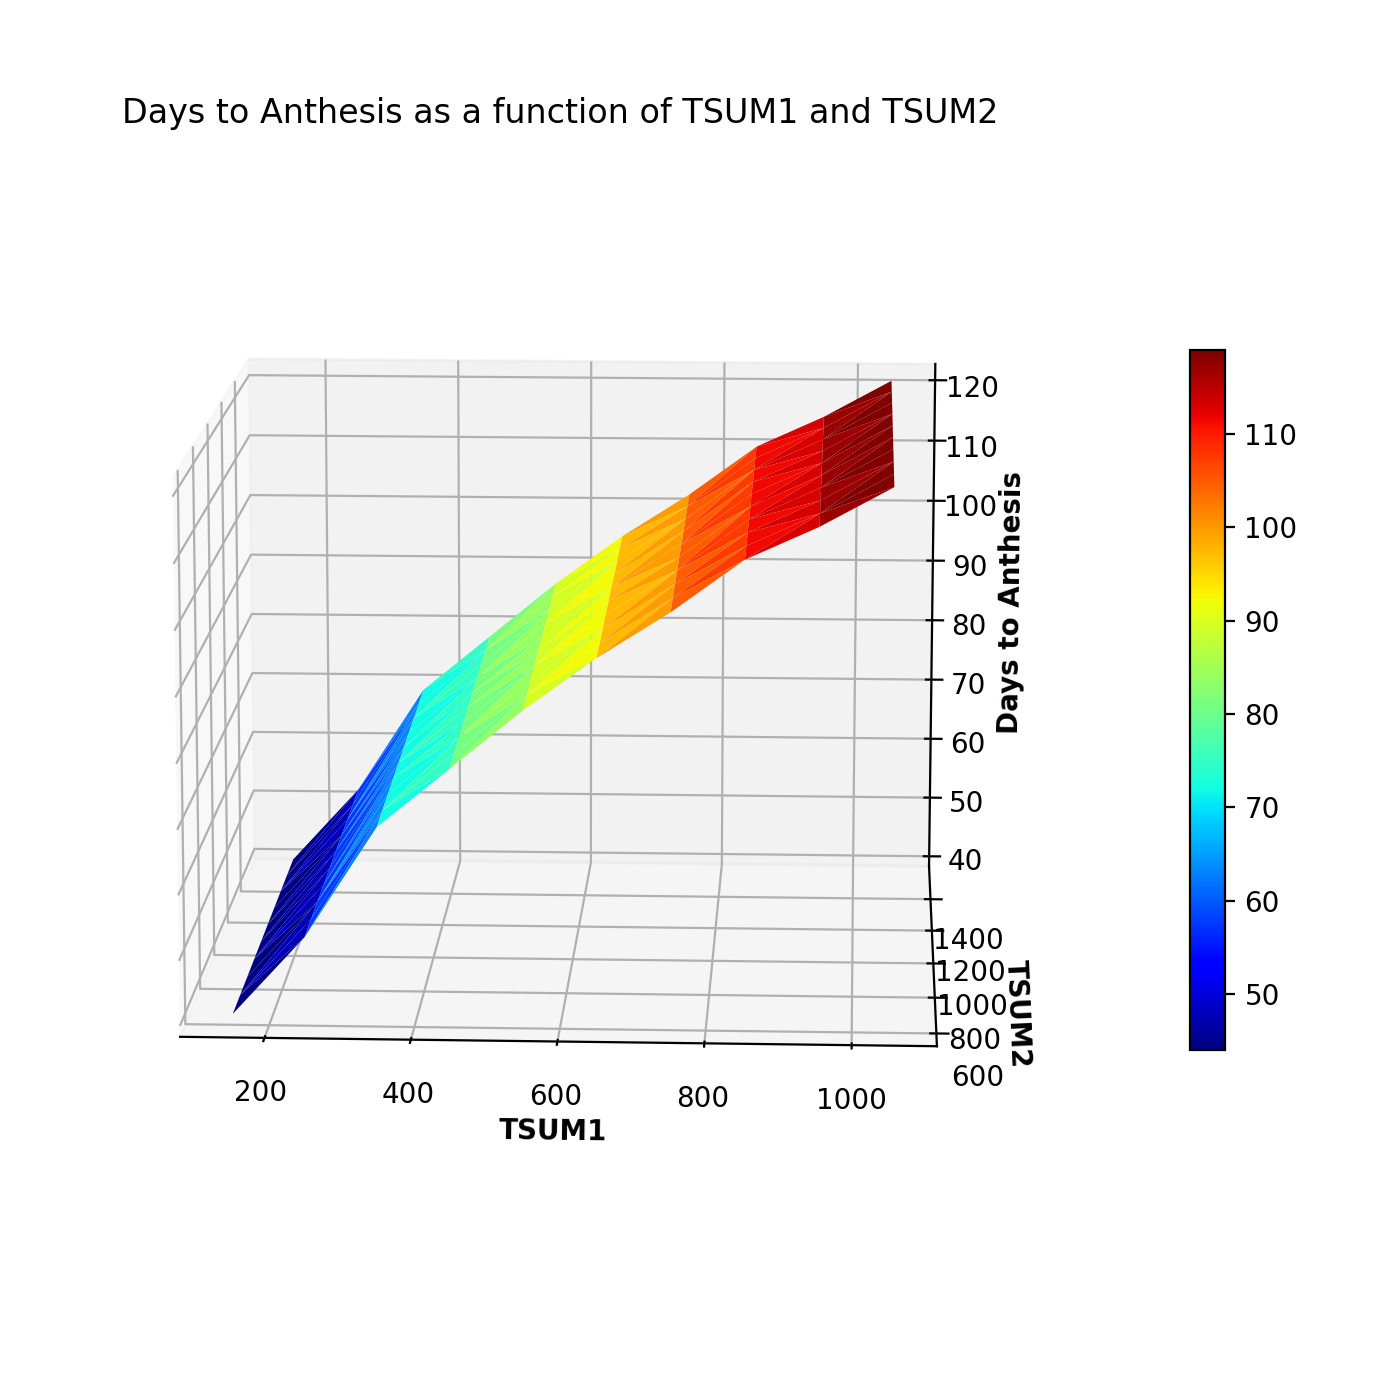

In [38]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig)

trisurf = ax.plot_trisurf(df.TSUM1, df.TSUM2, df['Days to Anthesis'], cmap=cm.jet, linewidth=0.2)
fig.colorbar(trisurf, ax = ax, shrink = 0.5) 
ax.set_title('Days to Anthesis as a function of TSUM1 and TSUM2') 

# Adding labels 
ax.set_xlabel('TSUM1', fontweight ='bold')  
ax.set_ylabel('TSUM2', fontweight ='bold')  
ax.set_zlabel('Days to Anthesis', fontweight ='bold') 

# show plot 
plt.show()

In [41]:
lower_bound = 600
upper_bound = 1550
param_name = "TSUM2"
n_samples = 20
target_variable = "DOA"
df = generate_dist2(param_name, lower_bound, upper_bound, n_samples, target_variable)
df['Days to Anthesis'] = pd.to_datetime(df['DOA']).apply(lambda x: (x-pd.to_datetime(emergence_date)).days)
df.head()

,DOA,Days to Anthesis
TSUM2,,
600.0,2006-07-07,98
650.0,2006-07-07,98
700.0,2006-07-07,98
750.0,2006-07-07,98
800.0,2006-07-07,98


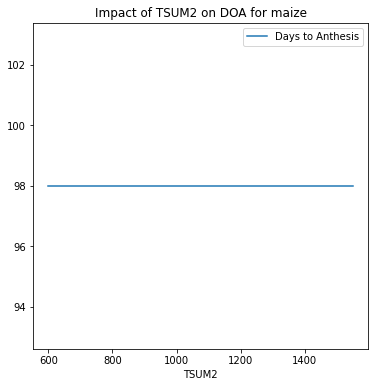

In [44]:
%matplotlib inline
r = df.plot(y='Days to Anthesis', title="Impact of {} on {} for maize".format(param_name, target_variable), figsize=(6,6))

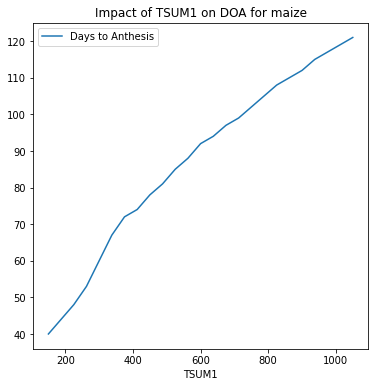

In [46]:
lower_bound = 150
upper_bound = 1050
param_name = "TSUM1"
n_samples = 25
target_variable = "DOA"
df = generate_dist2(param_name, lower_bound, upper_bound, n_samples, target_variable)
df['Days to Anthesis'] = pd.to_datetime(df['DOA']).apply(lambda x: (x-pd.to_datetime(emergence_date)).days)
r = df.plot(y='Days to Anthesis', title="Impact of {} on {} for maize".format(param_name, target_variable), figsize=(6,6))

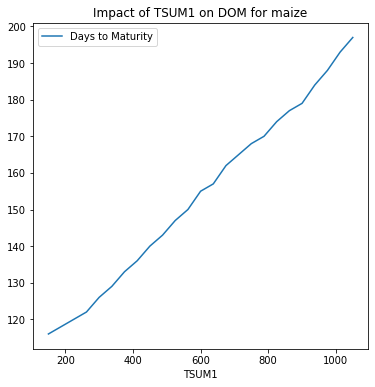

In [47]:
# DOM vs TSUM1 (day of maturity)
lower_bound = 150
upper_bound = 1050
param_name = "TSUM1"
n_samples = 25
target_variable = "DOM"
df = generate_dist2(param_name, lower_bound, upper_bound, n_samples, target_variable)
df['Days to Maturity'] = pd.to_datetime(df['DOM']).apply(lambda x: (x-pd.to_datetime(emergence_date)).days)
r = df.plot(y='Days to Maturity', title="Impact of {} on {} for maize".format(param_name, target_variable), figsize=(6,6))

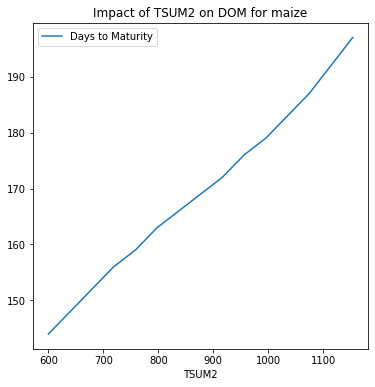

In [48]:
# DOM vs. TSUM2
lower_bound = 600
upper_bound = 1550
param_name = "TSUM2"
n_samples = 25
target_variable = "DOM"
df = generate_dist2(param_name, lower_bound, upper_bound, n_samples, target_variable)
df['Days to Maturity'] = pd.to_datetime(df['DOM']).apply(lambda x: (x-pd.to_datetime(emergence_date)).days)
r = df.plot(y='Days to Maturity', title="Impact of {} on {} for maize".format(param_name, target_variable), figsize=(6,6))

In [68]:
# How does crop calendar depend on TSUM1 and TSUM2?
lower_bounds = np.array([150, 600])
upper_bounds = np.array([1050, 1550])
param_names = ["TSUM1", "TSUM2"]
n_samples = 10
target_variable = "DOM" # Date of maturity
df = generate_multi_dist(param_names, lower_bounds, upper_bounds, n_samples, target_variable)
df['Days to Maturity'] = pd.to_datetime(df['DOM']).apply(lambda x: (x-pd.to_datetime(emergence_date)).days)
df.head()

,TSUM1,TSUM2,DOM,Days to Maturity
0,150.0,600.000000,2006-07-11,102.0
1,150.0,705.555556,2006-07-19,110.0
2,150.0,811.111111,2006-07-25,116.0
3,150.0,916.666667,2006-08-01,123.0
4,150.0,1022.222222,2006-08-10,132.0


In [69]:
df['Days to Maturity'].isna().any()

True

In [70]:
df = df.dropna()
df['Days to Maturity'].isna().any()

False

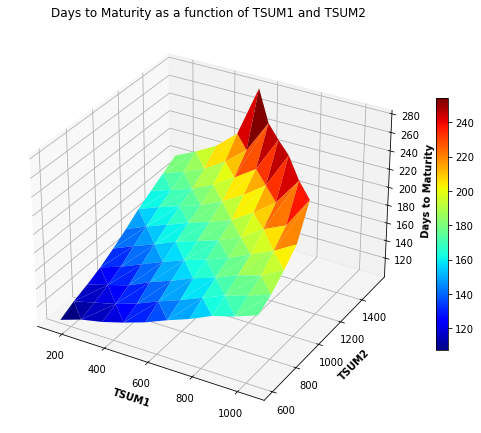

In [72]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig)

trisurf = ax.plot_trisurf(df.TSUM1, df.TSUM2, df['Days to Maturity'], cmap=cm.jet, linewidth=0.2)
fig.colorbar(trisurf, ax = ax, shrink = 0.5) 
ax.set_title('Days to Maturity as a function of TSUM1 and TSUM2') 

# Adding labels 
ax.set_xlabel('TSUM1', fontweight ='bold')  
ax.set_ylabel('TSUM2', fontweight ='bold')  
ax.set_zlabel('Days to Maturity', fontweight ='bold') 

# show plot 
plt.show()